# Modeling
We'll build 3 models
1. Word count model (sklearn) → Baseline
2. Deep learning (embedding with LSTM)
3. Fine-tunning 🤗 pre-trained transformer

In [1]:
! pip install -U scikit-learn
import sklearn
sklearn.__version__

'0.24.2'

In [2]:
import pandas as pd

df = pd.read_csv("../../data/df_notnull_notdup.csv")
df.head()

,ep_id,ep_name,show_name,description,label,desc_nonUrl
0,2QwU0zzueDDoi0fN3Kf0HR,#57 - Prof. Melanie Mitchell - Why AI is harde...,Machine Learning Street Talk,"Since its beginning in the 1950s, the field of...",machine learning,"Since its beginning in the 1950s, the field of..."
1,1ir7MrWUBwUI6AE7Na5diX,"#56 - Dr. Walid Saba, Gadi Singer, Prof. J. Ma...",Machine Learning Street Talk,It has been over three decades since the stati...,machine learning,It has been over three decades since the stati...
2,1ACeGKFk4syDdcRuuuSZP7,#55 Self-Supervised Vision Models (Dr. Ishan M...,Machine Learning Street Talk,Dr. Ishan Misra is a Research Scientist at Fac...,machine learning,Dr. Ishan Misra is a Research Scientist at Fac...
3,1vuc4azX8Mb0sl0lKOmxZi,#54 Gary Marcus and Luis Lamb - Neurosymbolic ...,Machine Learning Street Talk,"Professor Gary Marcus is a scientist, best-sel...",machine learning,"Professor Gary Marcus is a scientist, best-sel..."
4,6DrRmtpKKpH3yYJ6yPoMR2,#53 Quantum Natural Language Processing - Prof...,Machine Learning Street Talk,"Bob Coercke is a celebrated physicist, he's be...",machine learning,"Bob Coercke is a celebrated physicist, he's be..."


## Train-test split

In [3]:
from sklearn.model_selection import train_test_split

sequences, label = df['desc_nonUrl'], df['label']

X_train, X_test, y_train, y_test = train_test_split(sequences, label, stratify=label, test_size=0.2,
                                                    random_state=42)

print(f'Train size : {len(X_train)}')
print(f'Test  size : {len(X_test)}')

Train size : 10972
Test  size : 2743


In [4]:
y_train.value_counts()

kid                 1515
lifestyle           1322
business            1213
crime               1187
politics            1121
comedy              1078
sport                990
culture              946
machine learning     830
cooking              770
Name: label, dtype: int64

## 1) model_1 : baseline word count model

### Count tokenization

In [5]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vect = TextVectorization(
            max_tokens=500, output_mode="count", pad_to_max_tokens=True
        )

vect.adapt(X_train.values)

In [6]:
print(f'Vocabs sample : {vect.get_vocabulary()[:10]}')

Vocabs sample : ['[UNK]', 'the', 'and', 'to', 'of', 'a', 'in', 'unk', 'for', 'on']


In [7]:
sample_bow = vect(X_train.values[:3])

print(f'{X_train.values[:3]}')
print(sample_bow)

['This is one of those business cases that is easily validated from one or two individuals. My Normative originated due to the existing products available on the market not meeting the needs of at least two women: Danika Kelly, and her co-founder, Renee Kokts-Porietis. That validation appears to have been sufficient to allow My Normative to scale to reach a significant number of women, starting with the key age range from 18 to 35.\xa0 Machine learning, combined with empirical data, should provide the necessary informational tools to scale across the globe. Danika and her team appear to be content with tackling the North American market — for now!\xa0 §§§\xa0 To learn more about My Normative, click on one or more of the links below:\xa0 My Normative\xa0 Website | [UNK]\xa0 Instagram | @[UNK]ive\xa0 Facebook | @mynormative\xa0 Twitter | @mynormative\xa0 LinkedIn | [UNK]\xa0 §§§\xa0 Danika Kelly on LinkedIn | [UNK]   ---   Send in a voice message: [UNK]'
 'As exciting as summer is for al

### Label encoding (categorical)

In [8]:
X_train_count = vect(X_train.values)
X_test_count = vect(X_test.values)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train.values)
y_test_encoded = encoder.transform(y_test.values)

### Building model

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Use only first 200 word counts except the very first one
# which is a [UNK]

mnb = MultinomialNB()
mnb.fit(X_train_count[:,1:200], y_train_encoded)

dt = DecisionTreeClassifier()
dt.fit(X_train_count[:,1:200], y_train_encoded);

### Evaluation

In [11]:
from sklearn.metrics import classification_report

dt_y_pred = dt.predict(X_test_count[:,1:200])
mnb_y_pred = mnb.predict(X_test_count[:,1:200])

print("DT")
print(classification_report(y_test_encoded,dt_y_pred))

print("TREE")
print(classification_report(y_test_encoded,mnb_y_pred))

DT
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       303
           1       0.69      0.62      0.65       270
           2       0.43      0.49      0.46       193
           3       0.61      0.64      0.63       296
           4       0.43      0.42      0.43       237
           5       0.72      0.76      0.74       378
           6       0.51      0.53      0.52       331
           7       0.46      0.47      0.46       207
           8       0.56      0.54      0.55       280
           9       0.62      0.56      0.59       248

    accuracy                           0.57      2743
   macro avg       0.56      0.56      0.56      2743
weighted avg       0.57      0.57      0.57      2743

TREE
              precision    recall  f1-score   support

           0       0.50      0.42      0.46       303
           1       0.52      0.52      0.52       270
           2       0.28      0.22      0.25       193
           3    

## 2) model_2 : Deep learning (embedding LSTM)

### Building model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, InputLayer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vocab_size = 500

text_vect_layer = TextVectorization(max_tokens=vocab_size, output_sequence_length=vocab_size)
text_vect_layer.adapt(X_train.values)

model_2 = Sequential([
                      InputLayer(input_shape=(1,), dtype=tf.string),
                      text_vect_layer,
                      Embedding(text_vect_layer.vocabulary_size(), 64, 
                                mask_zero=True),  # Tell model to ignore padding token
                      LSTM(64),
                      Dense(32, activation='relu'),
                      Dense(10, activation='softmax')
            ])

In [17]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 64)           32000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 67,434
Trainable params: 67,434
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_train_ohe = tf.one_hot(y_train_encoded, depth=10)
y_test_ohe = tf.one_hot(y_test_encoded, depth=10)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
                monitor='val_loss', min_delta=0.001, 
                patience=3, restore_best_weights=False
            )
EPOCHS = 20
history = model_2.fit(X_train.values, y_train_ohe, 
            batch_size=32, epochs=EPOCHS, 
            validation_split=0.2, 
            #callbacks=[early_stop]
            )

Epoch 1/20
275/275 [==============================] - 50s 94ms/step - loss: 2.1465 - accuracy: 0.2199 - val_loss: 1.9505 - val_accuracy: 0.3034
Epoch 2/20
275/275 [==============================] - 24s 87ms/step - loss: 1.7089 - accuracy: 0.3952 - val_loss: 1.5508 - val_accuracy: 0.4661
Epoch 3/20
275/275 [==============================] - 24s 88ms/step - loss: 1.3947 - accuracy: 0.5282 - val_loss: 1.3378 - val_accuracy: 0.5622
Epoch 4/20
275/275 [==============================] - 24s 88ms/step - loss: 1.2201 - accuracy: 0.5991 - val_loss: 1.2395 - val_accuracy: 0.5973
Epoch 5/20
275/275 [==============================] - 24s 89ms/step - loss: 1.1340 - accuracy: 0.6339 - val_loss: 1.2332 - val_accuracy: 0.5932
Epoch 6/20
275/275 [==============================] - 24s 88ms/step - loss: 1.0242 - accuracy: 0.6661 - val_loss: 1.1092 - val_accuracy: 0.6501
Epoch 7/20
275/275 [==============================] - 24s 88ms/step - loss: 0.9569 - accuracy: 0.6895 - val_loss: 1.1366 - val_accuracy:

### Evaluation

In [34]:
model_2.evaluate(X_test.values, y_test_ohe)

86/86 [==============================] - 3s 33ms/step - loss: 1.0609 - accuracy: 0.7000


[1.0608502626419067, 0.6999635696411133]

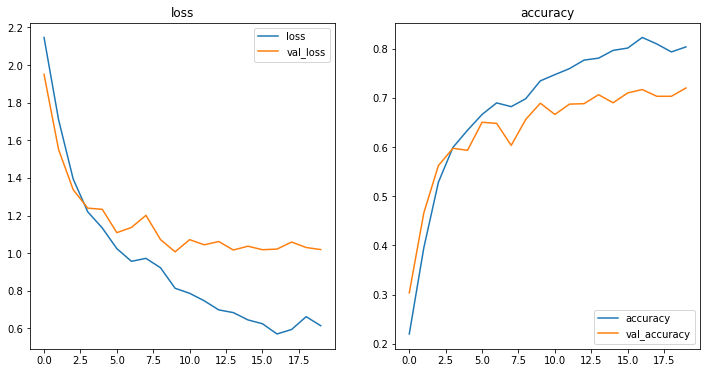

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(list(range(EPOCHS)), history.history['loss'], label='loss')
ax[0].plot(list(range(EPOCHS)), history.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend(loc='upper right')

ax[1].plot(list(range(EPOCHS)), history.history['accuracy'], label='accuracy')
ax[1].plot(list(range(EPOCHS)), history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('accuracy')
ax[1].legend(loc='lower right')
plt.show()

In [30]:
from sklearn.metrics import classification_report

y_pred_prob = model_2.predict(X_test.values)
y_pred = tf.argmax(y_pred_prob, axis=1)

print("model_2")
print(classification_report(y_test_encoded, y_pred.numpy()))

model_2
              precision    recall  f1-score   support

           0       0.58      0.78      0.66       303
           1       0.58      0.71      0.64       270
           2       0.73      0.44      0.55       193
           3       0.82      0.80      0.81       296
           4       0.58      0.58      0.58       237
           5       0.83      0.85      0.84       378
           6       0.66      0.65      0.66       331
           7       0.82      0.52      0.63       207
           8       0.77      0.69      0.73       280
           9       0.74      0.79      0.77       248

    accuracy                           0.70      2743
   macro avg       0.71      0.68      0.69      2743
weighted avg       0.71      0.70      0.70      2743



In [32]:
print(f'Tensorflow version : {tf.__version__}')
model_2.save("../../models/model_2")

Tensorflow version : 2.5.0


INFO:tensorflow:Assets written to: model_2/assets


INFO:tensorflow:Assets written to: model_2/assets


In [35]:
# Test SavedModel
test_model_2 = tf.keras.models.load_model('../../models/model_2')
test_model_2.evaluate(X_test.values, y_test_ohe)

86/86 [==============================] - 4s 33ms/step - loss: 1.0609 - accuracy: 0.7000


[1.0608502626419067, 0.6999635696411133]